In [1]:
import pymust
import numpy as np
import matplotlib.pyplot as plt

## 0. Generate the data
In this notebook interpolation will be used and compared with GT in this scenarios:
- PFIELD Spectrum interpolation
- Used interpolated spectrum for simus

In [2]:
param = pymust.getparam("P4-2V")
param.RXdelay = np.zeros((1,param.Nelements), dtype = np.float32)
options = pymust.utils.Options()
options.FrequencyStep = 1/4 #Make more frequency bins, as in simus

dels = pymust.txdelayPlane(param, 0)

# Define scatterers
xs=np.array([1,0.5,0,-0.5,-1])*1e-2
zs=np.array([3,5,7,5,3])*1e-2
RC = np.ones_like(xs)

# Define grid
xbound = np.array([-2e-2,2e-2])
zbound = np.array([0,9e-2])

x_range = np.linspace(xbound[0], xbound[1], 100)
z_range = np.linspace(zbound[0], zbound[1], 100)
X,Z = np.meshgrid(x_range, z_range)

x_range_fine = np.linspace(xbound[0], xbound[1], 150)
z_range_fine = np.linspace(zbound[0], zbound[1], 200)
X_fine, Z_fine = np.meshgrid(x_range_fine, z_range_fine)

P, SPECT_P, IDX = pymust.pfield(X, None, Z, dels, param, options=options)
P_fine, SPECT_P_fine, IDX_fine = pymust.pfield(X_fine, None, Z_fine, dels, param, options=options)


## 1. PFIELD Spectrum interpolation

In [3]:
# Interpolate the spectrum to a finer grid
interpolated_spectrum = pymust.interpolated.interpolate_spectrum(
    "linear_mag_nearest_phase",
    grid_values=SPECT_P,
    x_range=x_range,
    z_range=z_range,
    param=param,
    x_scatterers=X_fine.flatten(),
    z_scatterers=Z_fine.flatten(),
    freqs = param.f[IDX]
)
interpolated_spectrum = interpolated_spectrum.reshape(X_fine.shape[0], X_fine.shape[1], -1)


Max difference in magnitude: 49.52413514386574
Mean difference in magnitude: 0.36848466086987386


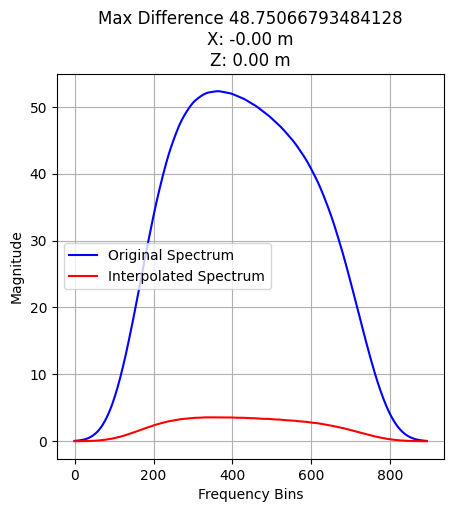

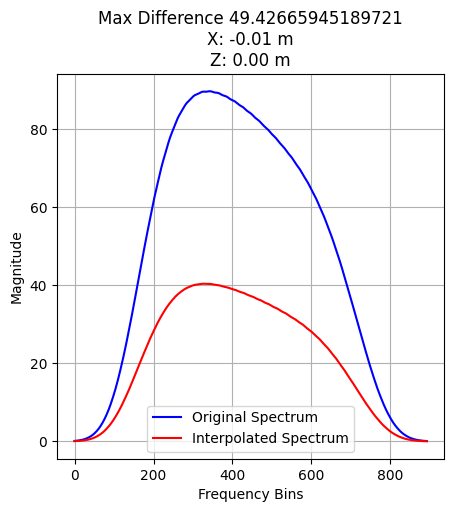

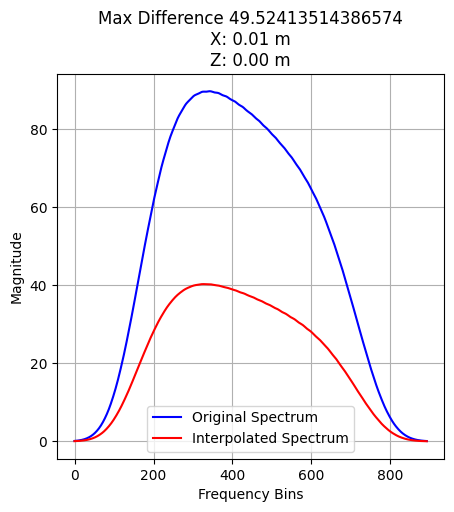

In [4]:
# Compare the interpolated spectrum with the original spectrum
difference_mag = np.abs(np.abs(interpolated_spectrum) - np.abs(SPECT_P_fine))
print("Max difference in magnitude:", np.max(difference_mag))
print("Mean difference in magnitude:", np.mean(difference_mag))

# Plot the top differences
num_plot = 3
indices = np.argsort(np.sum(difference_mag, axis=2).flatten())[-num_plot:]
indices = np.unravel_index(indices, difference_mag.shape[:2])
original_mag = np.abs(SPECT_P_fine[indices])
interpolated_mag = np.abs(interpolated_spectrum[indices])

for i in range(num_plot):
    plt.figure(figsize=(5, 5))
    plt.plot(original_mag[i], label='Original Spectrum', color='blue')
    plt.plot(interpolated_mag[i], label='Interpolated Spectrum', color='red')
    plt.title(f"""Max Difference {np.max(difference_mag[indices[0][i], indices[1][i]])}
X: {X_fine[indices[0][i], indices[1][i]]:.2f} m
Z: {Z_fine[indices[0][i], indices[1][i]]:.2f} m""")
    plt.xlabel('Frequency Bins')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid()
    plt.show()
    
    

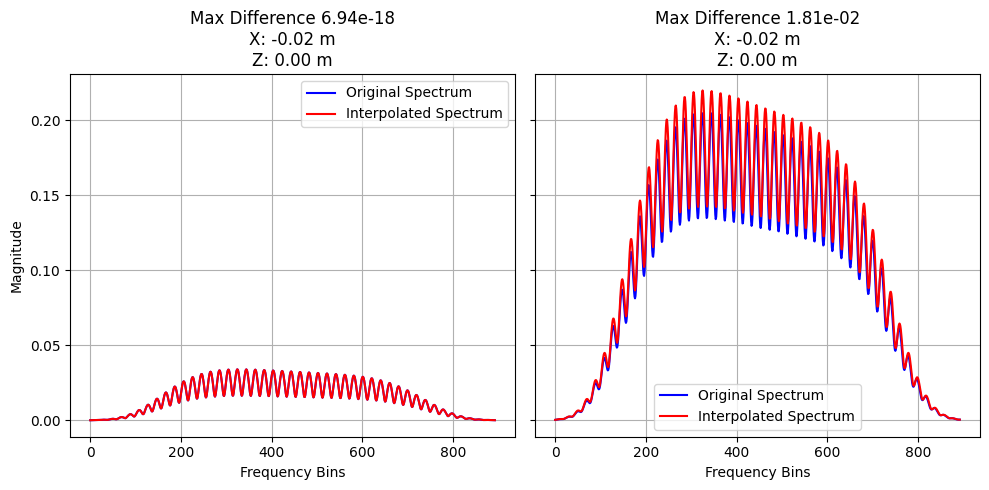

In [5]:
indice_on_grid = [0,0]
indice_off_grid = [1,1]

# Create figure and axes objects
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(np.abs(SPECT_P_fine[*indice_on_grid]), label='Original Spectrum', color='blue')
axes[0].plot(np.abs(interpolated_spectrum[*indice_on_grid]), label='Interpolated Spectrum', color='red')
axes[0].set_title(f"""Max Difference {np.max(difference_mag[*indice_on_grid]):.2e}
X: {X_fine[*indice_on_grid]:.2f} m
Z: {Z_fine[*indice_on_grid]:.2f} m""")
axes[0].set_xlabel('Frequency Bins')
axes[0].set_ylabel('Magnitude')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(np.abs(SPECT_P_fine[*indice_off_grid]), label='Original Spectrum', color='blue')
axes[1].plot(np.abs(interpolated_spectrum[*indice_off_grid]), label='Interpolated Spectrum', color='red')
axes[1].set_title(f"""Max Difference {np.max(difference_mag[*indice_off_grid]):.2e}
X: {X_fine[*indice_off_grid]:.2f} m
Z: {Z_fine[*indice_off_grid]:.2f} m""")
axes[1].set_xlabel('Frequency Bins')
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display the plot
fig.tight_layout()
plt.show()
    

In [6]:
import matplotlib.image as mpimg

np.random.seed(0)  # For reproducibility

def rgb2gray(rgb): #Function extracted from cell 12 of DW_echo_demo
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

I = mpimg.imread('..\examples\data\heart.jpg') #To be consistent with matlab, since the images are transposed in matlab. #Code line from cell 13 from DW_echo_demo
I = rgb2gray(I) if I.ndim == 3 else I
# Pseudorandom distribution of scatterers (depth is 15 cm)
xs,ys,zs,RC = pymust.genscat(np.array([np.nan, 9e-2]),1540/param.fc,I) #Code line from cell 13 from DW_echo_demo

xs = xs.flatten()
zs = zs.flatten()

spectrum_full = np.zeros((SPECT_P_fine.shape[0], SPECT_P_fine.shape[1], len(param.f)), dtype=np.complex64)
spectrum_full[:, :, IDX] = SPECT_P_fine

## 2. Usage example of interpolated simus

In [13]:
RF_full, RF_SPECT_full = pymust.interpolated.simus(
    x_range=x_range_fine,
    z_range=z_range_fine,
    P_SPECT_grid=spectrum_full,
    x_scatterers=xs,
    z_scatterers=zs,
    interpolator_name="linear_mag_nearest_phase",
    freqs=param.f,
    RC=RC,
    param=param,
    # harmonic=True
)

In [14]:
RF_fast, RF_SPECT_fast = pymust.interpolated.simus(
    x_range=x_range_fine,
    z_range=z_range_fine,
    P_SPECT_grid=SPECT_P_fine,
    x_scatterers=xs,
    z_scatterers=zs,
    interpolator_name="linear_mag_nearest_phase",
    freqs=param.f,
    IDX=IDX,
    RC=RC,
    param=param,
    # harmonic=True
)